# HacktionPotential — Pipeline PyTorch

Ce notebook fait tout en 3 parties :
1. **Conversion** TFRecord → `.pt`
2. **Exploration** des données
3. **Training** 100% PyTorch

---
## 0. Setup & Configuration

In [1]:
%matplotlib inline

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from types import SimpleNamespace

In [2]:
# ============================================================
# CONFIGURATION — Adapte ces valeurs à ton setup
# ============================================================

dataset_dir = os.path.abspath("dataset")
mouse = "M1199_PAG"
stride = 4
window_size = 108  # 36, 108, ou 252

# Fichiers
tfrec_file = f"{mouse}_stride{stride}_win{window_size}_test.tfrec"
json_file = f"{mouse}.json"
pt_output = f"data/{mouse}_stride{stride}_win{window_size}.pt"

print(f"TFRecord : {os.path.join(dataset_dir, tfrec_file)}")
print(f"JSON     : {os.path.join(dataset_dir, json_file)}")
print(f"Sortie   : {pt_output}")

TFRecord : /Users/ippo/Downloads/hackathon/theta-gang-master/dataset/M1199_PAG_stride4_win108_test.tfrec
JSON     : /Users/ippo/Downloads/hackathon/theta-gang-master/dataset/M1199_PAG.json
Sortie   : data/M1199_PAG_stride4_win108.pt


In [3]:
# Charger les paramètres depuis le JSON
with open(os.path.join(dataset_dir, json_file), "r") as f:
    params_raw = json.load(f)

params = SimpleNamespace(**params_raw)

# Extraire nChannelsPerGroup depuis le JSON
params.nChannelsPerGroup = []
for g in range(params.nGroups):
    params.nChannelsPerGroup.append(params_raw[f"group{g}"]["nChannels"])

print(f"nGroups = {params.nGroups}")
print(f"nChannelsPerGroup = {params.nChannelsPerGroup}")

nGroups = 4
nChannelsPerGroup = [6, 4, 6, 4]


---
## 1. Chargement des données (Parquet → RAM)

On charge le Parquet directement en mémoire et on l'utilise tel quel. **Pas de conversion .pt, pas de TensorFlow.**


In [4]:
import pyarrow.parquet as pq
import time

parquet_file = f"{mouse}_stride{stride}_win{window_size}_test.parquet"
parquet_path = os.path.join(dataset_dir, parquet_file)

print(f"Lecture de {parquet_path}...")
t0 = time.time()

pf = pq.ParquetFile(parquet_path)
df = pf.read().to_pandas()

elapsed = time.time() - t0
print(f"Chargé en {elapsed:.1f}s — {len(df)} lignes, {len(df.columns)} colonnes")
print(f"Colonnes : {list(df.columns)}")


Lecture de /Users/ippo/Downloads/hackathon/theta-gang-master/dataset/M1199_PAG_stride4_win108_test.parquet...
Chargé en 32.0s — 62257 lignes, 18 colonnes
Colonnes : ['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat', 'length', 'pos', 'pos_index', 'time', 'time_behavior', 'speedMask', 'indexInDat_raw', 'indices0', 'zeroForGather', 'indices1', 'indices2', 'indices3']


In [5]:
class ParquetSpikeDataset(torch.utils.data.Dataset):
    """Dataset PyTorch qui lit directement depuis un DataFrame Parquet en RAM.
    Pas de conversion, pas de .pt — on accède aux lignes à la volée."""

    def __init__(self, dataframe, params, indices=None):
        self.df = dataframe
        self.params = params
        self.n_groups = params.nGroups
        self.indices = indices if indices is not None else np.arange(len(dataframe))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        row = self.df.iloc[self.indices[idx]]
        out = {}

        # Position cible (x, y)
        pos = np.array(row["pos"], dtype=np.float32)
        target = torch.tensor(pos[:2], dtype=torch.float32)

        # Groupes
        groups = np.array(row["groups"], dtype=np.int64)
        out["groups"] = torch.from_numpy(groups)

        # Waveforms par shank
        for g in range(self.n_groups):
            nCh = self.params.nChannelsPerGroup[g]
            raw = np.array(row[f"group{g}"], dtype=np.float32).reshape(-1)

            if raw.shape[0] > 0 and raw.shape[0] % (nCh * 32) == 0:
                waveforms = raw.reshape(-1, nCh, 32)
                # Filtrer spikes vides
                non_zero_mask = ~np.all(waveforms == 0, axis=(1, 2))
                waveforms = waveforms[non_zero_mask]

                # Remapper indices
                old_to_new = np.zeros(len(non_zero_mask) + 1, dtype=np.int32)
                new_i = 1
                for oi in range(len(non_zero_mask)):
                    if non_zero_mask[oi]:
                        old_to_new[oi + 1] = new_i
                        new_i += 1

                indices_col = f"indices{g}"
                if indices_col in row.index:
                    raw_idx = np.array(row[indices_col], dtype=np.int32).reshape(-1)
                    raw_idx = np.clip(raw_idx, 0, len(old_to_new) - 1)
                    out[f"indices{g}"] = torch.from_numpy(old_to_new[raw_idx])
                else:
                    out[f"indices{g}"] = torch.zeros(len(groups), dtype=torch.long)

                out[f"group{g}"] = torch.from_numpy(waveforms)
            else:
                out[f"group{g}"] = torch.zeros((0, nCh, 32), dtype=torch.float32)
                out[f"indices{g}"] = torch.zeros(len(groups), dtype=torch.long)

        return out, target

print(f"ParquetSpikeDataset prêt — {len(df)} exemples disponibles")


ParquetSpikeDataset prêt — 62257 exemples disponibles


In [6]:
def collate_fn(batch):
    """Pad les séquences de longueurs variables."""
    inputs_list, targets_list = zip(*batch)
    B = len(inputs_list)

    max_seq = max(b["groups"].shape[0] for b in inputs_list)
    max_spikes = {}
    for g in range(params.nGroups):
        max_spikes[g] = max(max(b[f"group{g}"].shape[0] for b in inputs_list), 1)

    result = {}

    # Groups — pad avec -1
    groups = torch.full((B, max_seq), -1, dtype=torch.long)
    for i, b in enumerate(inputs_list):
        L = b["groups"].shape[0]
        groups[i, :L] = b["groups"]
    result["groups"] = groups
    result["mask"] = (groups != -1).float()

    # Indices — pad avec 0 (→ null spike)
    for g in range(params.nGroups):
        idx = torch.zeros((B, max_seq), dtype=torch.long)
        for i, b in enumerate(inputs_list):
            L = b[f"indices{g}"].shape[0]
            idx[i, :L] = b[f"indices{g}"]
        idx = idx.clamp(max=max_spikes[g])
        result[f"indices{g}"] = idx

    # Waveforms — pad avec des zéros
    for g in range(params.nGroups):
        nCh = params.nChannelsPerGroup[g]
        ms = max_spikes[g]
        wf = torch.zeros((B, ms, nCh, 32), dtype=torch.float32)
        for i, b in enumerate(inputs_list):
            n = b[f"group{g}"].shape[0]
            if n > 0:
                wf[i, :n] = b[f"group{g}"]
        result[f"group{g}"] = wf

    result["pos"] = torch.stack(targets_list)
    return result


In [7]:
# Speed mask : filtrer les exemples où la souris bouge
speed_col = "speedMask"
if speed_col in df.columns:
    # Gérer différents formats de speedMask
    def parse_speed(val):
        if isinstance(val, (bytes, np.bytes_)):
            return val == b"\x01"
        return bool(val)
    speed_mask = df[speed_col].apply(parse_speed).values
    valid_indices = np.where(speed_mask)[0]
    print(f"SpeedMask: {len(valid_indices)}/{len(df)} exemples rapides ({100*len(valid_indices)/len(df):.1f}%)")
else:
    valid_indices = np.arange(len(df))
    print("Pas de speedMask — tous les exemples utilisés")

# Shuffle déterministe + split 80/20
rng = np.random.RandomState(42)
shuffled = rng.permutation(valid_indices)
n_train = int(0.8 * len(shuffled))

train_ds = ParquetSpikeDataset(df, params, indices=shuffled[:n_train])
val_ds = ParquetSpikeDataset(df, params, indices=shuffled[n_train:])

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=0)

print(f"\nTrain: {len(train_ds)} exemples, {len(train_loader)} batches")
print(f"Val  : {len(val_ds)} exemples, {len(val_loader)} batches")


SpeedMask: 22974/62257 exemples rapides (36.9%)

Train: 18379 exemples, 288 batches
Val  : 4595 exemples, 72 batches


---
## 2. Exploration des données

Directement depuis le DataFrame en mémoire.


In [10]:
# Déjà en mémoire — pas besoin de recharger
print(f"{len(df)} exemples en mémoire")
print(f"Colonnes: {list(df.columns)}")
df.head(3)


62257 exemples en mémoire
Colonnes: ['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat', 'length', 'pos', 'pos_index', 'time', 'time_behavior', 'speedMask', 'indexInDat_raw', 'indices0', 'zeroForGather', 'indices1', 'indices2', 'indices3']


,group0,group1,group2,group3,groups,indexInDat,length,pos,pos_index,time,time_behavior,speedMask,indexInDat_raw,indices0,zeroForGather,indices1,indices2,indices3
0,"[4.4905214, 4.289115, 2.397555, 4.9237323, 1.9...","[-2.7625754, -0.041320268, 1.1797833, 0.106313...","[-0.3823218, 0.26588744, -0.06600025, -2.07445...","[-11.746682, -9.458845, -10.755431, -9.787609,...","[1, 0, 2, 2, 0, 1, 0, 3, 1, 3, 0, 3, 2, 1, 3, ...","[216059597, 216059611, 216059622, 216059703, 2...",[73],"[0.2380991101561953, 0.8049437338425552, -2.89...",[156622],[10803.034],[10803.116],[False],"[216059597, 216059611, 216059622, 216059703, 2...","[0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 4, 0, ...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 0, 0, 4, ..."
1,"[4.744651, -0.46449965, -4.9791293, -1.4566978...","[-6.5401173, -9.58557, -5.05113, -4.1449285, -...","[1.3171366, 3.385435, 5.466522, 3.262233, 2.73...","[-6.449205, -3.7243226, -0.94095474, 4.024223,...","[0, 2, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 0, 2, ...","[216060331, 216060361, 216060368, 216060406, 2...",[66],"[0.2380991101561953, 0.8049437338425552, -2.89...",[156622],[10803.073],[10803.116],[False],"[216060331, 216060361, 216060368, 216060406, 2...","[1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...","[0, 0, 1, 2, 0, 0, 3, 4, 0, 5, 6, 7, 0, 0, 0, ..."
2,"[-4.867984, -2.0415728, -2.2092433, -2.701678,...","[-4.509027, -2.4044425, -4.283478, -8.628607, ...","[-3.866517, -3.463913, -1.9244556, -2.5225954,...","[-8.362156, -7.7195864, -5.204652, -9.035585, ...","[1, 0, 2, 1, 0, 1, 3, 1, 1, 0, 2, 2, 3, 1, 2, ...","[216061051, 216061065, 216061069, 216061083, 2...",[78],"[0.22347367133862373, 0.800746161144787, -3.03...",[156623],[10803.101],[10803.186],[True],"[216061051, 216061065, 216061069, 216061083, 2...","[0, 1, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 2, 0, 3, 0, 4, 5, 0, 0, 0, 0, 6, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 4, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, ..."


### 2.1 Structure d'un exemple

In [11]:
row = df.iloc[0]
print("Clés disponibles :")
for key in row.index:
    val = row[key]
    if isinstance(val, (list, np.ndarray)):
        arr = np.array(val)
        print(f"  {key:20s} → array   shape={str(arr.shape):15s} dtype={arr.dtype}")
    else:
        print(f"  {key:20s} → {type(val).__name__:8s} = {val}")


Clés disponibles :
  group0               → array   shape=(2880,)         dtype=float32
  group1               → array   shape=(2688,)         dtype=float32
  group2               → array   shape=(3456,)         dtype=float32
  group3               → array   shape=(2432,)         dtype=float32
  groups               → array   shape=(73,)           dtype=int64
  indexInDat           → array   shape=(73,)           dtype=int64
  length               → array   shape=(1,)            dtype=int64
  pos                  → array   shape=(4,)            dtype=float64
  pos_index            → array   shape=(1,)            dtype=int64
  time                 → array   shape=(1,)            dtype=float32
  time_behavior        → array   shape=(1,)            dtype=float32
  speedMask            → array   shape=(1,)            dtype=bool
  indexInDat_raw       → array   shape=(73,)           dtype=int64
  indices0             → array   shape=(73,)           dtype=int32
  zeroForGather        → array

### 2.2 Positions cibles

In [12]:
positions = np.stack(df["pos"].values)[:, :2]
times = df["time"].values.astype(np.float32)

print(f"Shape positions : {positions.shape}")
for i, axis in enumerate(["x", "y"]):
    v = positions[:, i]
    print(f"  {axis}: min={v.min():.4f}  max={v.max():.4f}  mean={v.mean():.4f}  std={v.std():.4f}")


Shape positions : (62257, 2)
  x: min=0.0036  max=0.9896  mean=0.5177  std=0.3304
  y: min=-0.0051  max=1.0095  mean=0.5858  std=0.3370


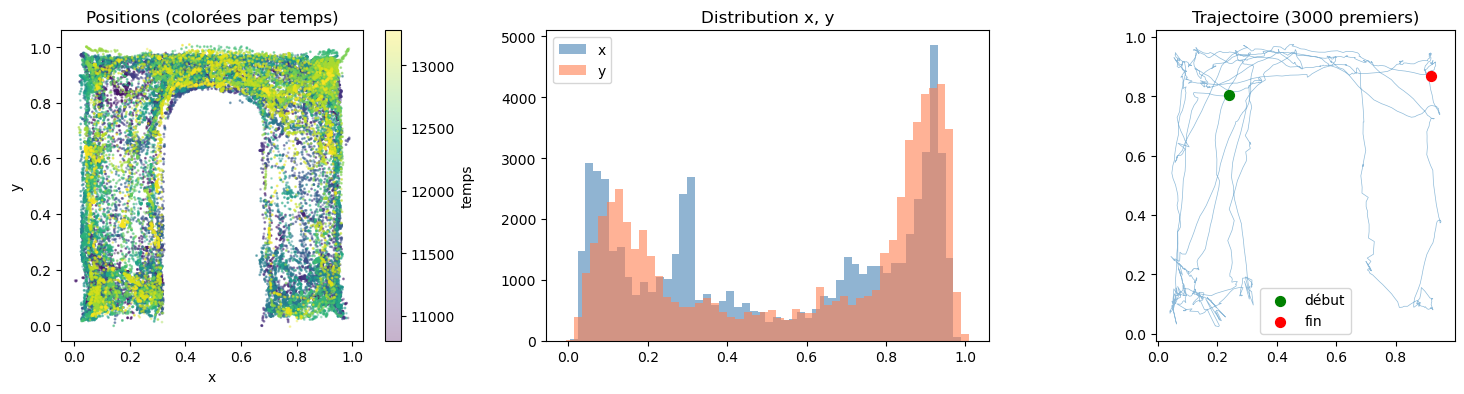

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Positions 2D
ax = axes[0]
sc = ax.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.3, c=times, cmap="viridis")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Positions (colorées par temps)")
ax.set_aspect("equal")
plt.colorbar(sc, ax=ax, label="temps")

# Histogrammes
ax = axes[1]
ax.hist(positions[:, 0], bins=50, alpha=0.6, label="x", color="steelblue")
ax.hist(positions[:, 1], bins=50, alpha=0.6, label="y", color="coral")
ax.set_title("Distribution x, y")
ax.legend()

# Trajectoire
ax = axes[2]
sorted_idx = np.argsort(times)
n_show = min(3000, len(sorted_idx))
idx = sorted_idx[:n_show]
ax.plot(positions[idx, 0], positions[idx, 1], lw=0.5, alpha=0.5)
ax.scatter(positions[idx[0], 0], positions[idx[0], 1], c="green", s=50, zorder=5, label="début")
ax.scatter(positions[idx[-1], 0], positions[idx[-1], 1], c="red", s=50, zorder=5, label="fin")
ax.set_title(f"Trajectoire ({n_show} premiers)")
ax.set_aspect("equal")
ax.legend()

plt.tight_layout()
plt.show()

### 2.3 Séquences de spikes

In [14]:
seq_lengths = np.array([np.sum(np.array(g) != -1) for g in df["groups"].values])

print(f"Longueur séquence (spikes valides) :")
print(f"  min={seq_lengths.min()}  max={seq_lengths.max()}  "
      f"mean={seq_lengths.mean():.1f}  median={np.median(seq_lengths):.0f}")

if "speedMask" in df.columns:
    def parse_speed(val):
        if isinstance(val, (bytes, np.bytes_)):
            return val == b"\x01"
        return bool(val)
    speed_mask = df["speedMask"].apply(parse_speed).values
    print(f"\nSpeedMask : {speed_mask.sum()} rapides / {len(speed_mask)} total "
          f"({100*speed_mask.mean():.1f}%)")


Longueur séquence (spikes valides) :
  min=2  max=190  mean=54.8  median=53

SpeedMask : 22974 rapides / 62257 total (36.9%)


  group0: min=  1  max= 30  mean=12.8
  group1: min=  1  max= 32  mean=12.3
  group2: min=  0  max= 42  mean=15.6
  group3: min=  0  max= 31  mean=10.8


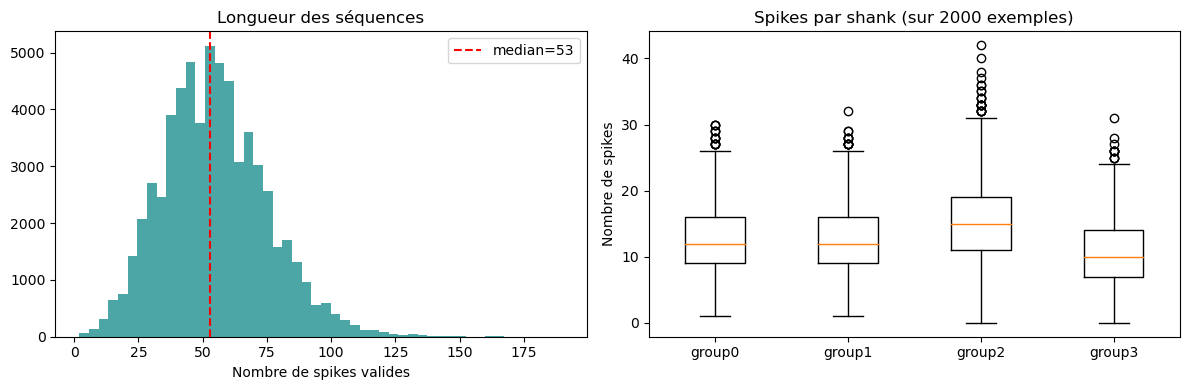

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution longueurs
ax = axes[0]
ax.hist(seq_lengths, bins=50, color="teal", alpha=0.7)
ax.axvline(np.median(seq_lengths), color="red", ls="--", label=f"median={np.median(seq_lengths):.0f}")
ax.set_xlabel("Nombre de spikes valides")
ax.set_title("Longueur des séquences")
ax.legend()

# Spikes par group (on compte les waveforms non-vides)
ax = axes[1]
spikes_per_group = []
for g in range(params.nGroups):
    nCh = params.nChannelsPerGroup[g]
    counts = []
    for raw in df[f"group{g}"].values[:2000]:  # subset pour la vitesse
        arr = np.array(raw, dtype=np.float32).reshape(-1)
        if arr.shape[0] > 0 and arr.shape[0] % (nCh * 32) == 0:
            wf = arr.reshape(-1, nCh, 32)
            n_valid = int(np.sum(~np.all(wf == 0, axis=(1, 2))))
            counts.append(n_valid)
        else:
            counts.append(0)
    spikes_per_group.append(counts)
    c = np.array(counts)
    print(f"  group{g}: min={c.min():3d}  max={c.max():3d}  mean={c.mean():.1f}")

ax.boxplot(spikes_per_group, labels=[f"group{g}" for g in range(params.nGroups)])
ax.set_ylabel("Nombre de spikes")
ax.set_title("Spikes par shank (sur 2000 exemples)")

plt.tight_layout()
plt.show()


### 2.4 Waveforms

In [16]:
# Stats globales sur les waveforms
for g in range(params.nGroups):
    nCh = params.nChannelsPerGroup[g]
    all_wf = []
    for raw in df[f"group{g}"].values[:200]:
        arr = np.array(raw, dtype=np.float32).reshape(-1)
        if arr.shape[0] > 0 and arr.shape[0] % (nCh * 32) == 0:
            wf = arr.reshape(-1, nCh, 32)
            wf = wf[~np.all(wf == 0, axis=(1, 2))]
            if len(wf) > 0:
                all_wf.append(wf)
    if all_wf:
        wfs = np.concatenate(all_wf)
        print(f"group{g}: shape/spike=({nCh}, 32)  "
              f"min={wfs.min():.2f}  max={wfs.max():.2f}  mean={wfs.mean():.2f}  std={wfs.std():.2f}")


group0: shape/spike=(6, 32)  min=-218.61  max=159.92  mean=-2.11  std=17.51
group1: shape/spike=(4, 32)  min=-106.85  max=42.60  mean=-2.42  std=8.85
group2: shape/spike=(6, 32)  min=-135.55  max=55.71  mean=-1.66  std=8.87
group3: shape/spike=(4, 32)  min=-101.97  max=43.68  mean=-2.42  std=9.34


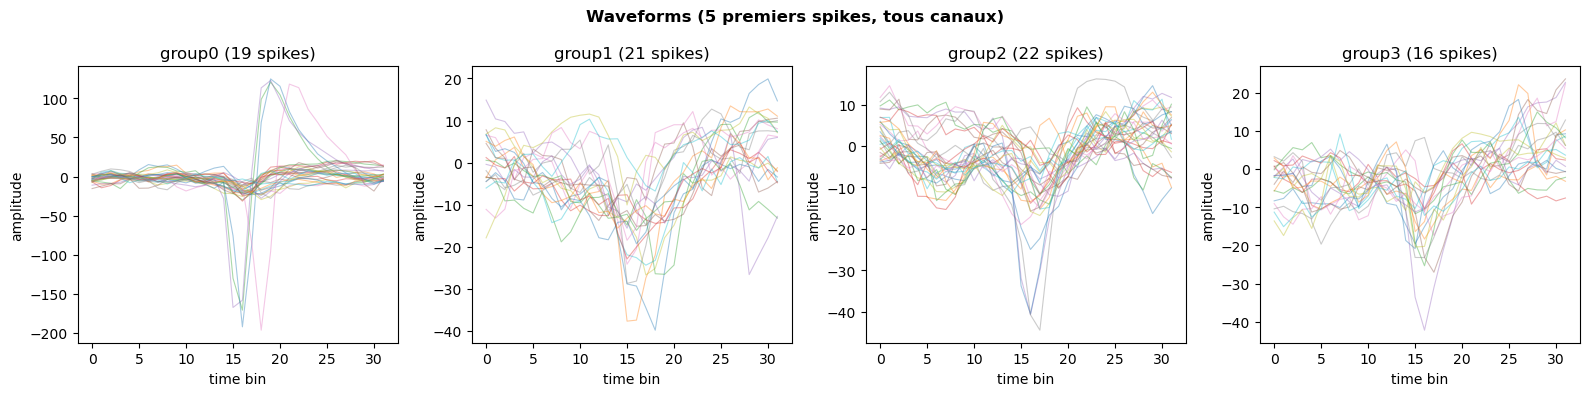

In [17]:
# Visualiser des waveforms
fig, axes = plt.subplots(1, params.nGroups, figsize=(4 * params.nGroups, 4))
if params.nGroups == 1:
    axes = [axes]

row = df.iloc[2]
for g in range(params.nGroups):
    ax = axes[g]
    nCh = params.nChannelsPerGroup[g]
    raw = np.array(row[f"group{g}"], dtype=np.float32).reshape(-1)
    if raw.shape[0] > 0 and raw.shape[0] % (nCh * 32) == 0:
        wf = raw.reshape(-1, nCh, 32)
        wf = wf[~np.all(wf == 0, axis=(1, 2))]
        n_show = min(5, wf.shape[0])
        for s in range(n_show):
            for ch in range(nCh):
                ax.plot(wf[s, ch, :], alpha=0.4, lw=0.8)
        ax.set_title(f"group{g} ({wf.shape[0]} spikes)")
    else:
        ax.set_title(f"group{g} (vide)")
    ax.set_xlabel("time bin")
    ax.set_ylabel("amplitude")

plt.suptitle("Waveforms (5 premiers spikes, tous canaux)", fontweight="bold")
plt.tight_layout()
plt.show()


---
## 3. Training PyTorch

100% PyTorch à partir d'ici.

### 3.1 Dataset & DataLoader

In [18]:
class SpikeDataset(Dataset):
    def __init__(self, examples, params, speed_filter=True):
        self.params = params
        if speed_filter:
            self.examples = [ex for ex in examples if ex["speedMask"]]
            print(f"  Speed filter: {len(self.examples)}/{len(examples)} exemples gardés")
        else:
            self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        out = {}
        out["pos"] = torch.tensor(ex["pos"], dtype=torch.float32)
        out["groups"] = torch.tensor(ex["groups"], dtype=torch.long)
        for g in range(self.params.nGroups):
            out[f"group{g}"] = torch.tensor(ex[f"group{g}"], dtype=torch.float32)
            out[f"indices{g}"] = torch.tensor(ex[f"indices{g}"], dtype=torch.long)
        return out

In [19]:
def collate_fn(batch):
    """Pad les séquences de longueurs variables."""
    B = len(batch)
    max_seq = max(b["groups"].shape[0] for b in batch)
    max_spikes = {}
    for g in range(params.nGroups):
        max_spikes[g] = max(max(b[f"group{g}"].shape[0] for b in batch), 1)

    result = {}

    # Groups — pad avec -1
    groups = torch.full((B, max_seq), -1, dtype=torch.long)
    for i, b in enumerate(batch):
        L = b["groups"].shape[0]
        groups[i, :L] = b["groups"]
    result["groups"] = groups
    result["mask"] = (groups != -1).float()

    # Indices — pad avec 0 (→ null spike)
    for g in range(params.nGroups):
        idx = torch.zeros((B, max_seq), dtype=torch.long)
        for i, b in enumerate(batch):
            L = b[f"indices{g}"].shape[0]
            idx[i, :L] = b[f"indices{g}"]
        # Clipper pour éviter out-of-bounds dans gather 
        # (max valide = max_spikes[g], car on ajoute +1 null spike dans le modèle)
        idx = idx.clamp(max=max_spikes[g])
        result[f"indices{g}"] = idx

    # Waveforms — pad avec des zéros
    for g in range(params.nGroups):
        nCh = params.nChannelsPerGroup[g]
        ms = max_spikes[g]
        wf = torch.zeros((B, ms, nCh, 32), dtype=torch.float32)
        for i, b in enumerate(batch):
            n = b[f"group{g}"].shape[0]
            if n > 0:
                wf[i, :n] = b[f"group{g}"]
        result[f"group{g}"] = wf

    result["pos"] = torch.stack([b["pos"] for b in batch])
    return result


In [20]:
# Train/Val déjà créés dans la section 1
# On vérifie juste que tout est OK
batch = next(iter(train_loader))
print("Shapes du premier batch :")
for k, v in batch.items():
    print(f"  {k:15s} → {v.shape}")


Shapes du premier batch :
  groups          → torch.Size([64, 105])
  mask            → torch.Size([64, 105])
  indices0        → torch.Size([64, 105])
  indices1        → torch.Size([64, 105])
  indices2        → torch.Size([64, 105])
  indices3        → torch.Size([64, 105])
  group0          → torch.Size([64, 30, 6, 32])
  group1          → torch.Size([64, 25, 4, 32])
  group2          → torch.Size([64, 33, 6, 32])
  group3          → torch.Size([64, 30, 4, 32])
  pos             → torch.Size([64, 2])


In [21]:
# (batch vérifié ci-dessus)


### 3.2 Modèle

In [22]:
class SpikeDecoder(nn.Module):
    """
    Décodeur de position (x, y) à partir de séquences de spikes.
    
    1. Embedding linéaire par shank
    2. Null spike trick + gather
    3. Sélection du shank actif (one-hot)
    4. Masked average pooling
    5. Tête linéaire → (x, y)
    """

    def __init__(self, params, n_features=64):
        super().__init__()
        self.params = params
        self.n_features = n_features
        self.n_groups = params.nGroups

        self.embedders = nn.ModuleList()
        for g in range(self.n_groups):
            n_flat = params.nChannelsPerGroup[g] * 32
            self.embedders.append(nn.Sequential(
                nn.Linear(n_flat, n_features),
                nn.ReLU(),
            ))

        self.head = nn.Linear(n_features, 2)

    def forward(self, batch):
        groups_seq = batch["groups"]  # (B, L)
        mask = batch["mask"]          # (B, L)
        B, L = groups_seq.shape

        gathered_list = []
        for g in range(self.n_groups):
            wf = batch[f"group{g}"]  # (B, n_spikes, nCh, 32)
            n_spikes = wf.shape[1]
            nCh = self.params.nChannelsPerGroup[g]

            wf_flat = wf.reshape(B, n_spikes, nCh * 32)
            emb = self.embedders[g](wf_flat)  # (B, n_spikes, n_features)

            # Null spike trick: index 0 → vecteur zéro
            null = torch.zeros(B, 1, self.n_features, device=emb.device)
            full_emb = torch.cat([null, emb], dim=1)  # (B, 1+n_spikes, n_features)

            # Clamp indices to valid range [0, n_spikes]
            raw_idx = batch[f"indices{g}"]  # (B, L)
            safe_idx = raw_idx.clamp(min=0, max=n_spikes)  # max valid = n_spikes (0-indexed after null)
            
            # Gather
            idx = safe_idx.unsqueeze(-1).expand(-1, -1, self.n_features)
            gathered = torch.gather(full_emb, dim=1, index=idx)  # (B, L, n_features)
            gathered_list.append(gathered)

        # Stack shanks: (B, L, nGroups, n_features)
        stacked = torch.stack(gathered_list, dim=2)

        # Sélection shank actif via one-hot
        g_clamped = groups_seq.clamp(min=0)
        one_hot = F.one_hot(g_clamped, num_classes=self.n_groups).float()
        seq_features = (stacked * one_hot.unsqueeze(-1)).sum(dim=2)  # (B, L, n_features)

        # Masked average pooling
        mask_exp = mask.unsqueeze(-1)
        total = (seq_features * mask_exp).sum(dim=1)
        count = mask_exp.sum(dim=1).clamp(min=1e-7)
        context = total / count

        return self.head(context)  # (B, 2)


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

N_FEATURES = 64
model = SpikeDecoder(params, n_features=N_FEATURES).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Paramètres: {n_params:,}")
print(model)

Device: cpu
Paramètres: 41,346
SpikeDecoder(
  (embedders): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (head): Linear(in_features=64, out_features=2, bias=True)
)


### 3.3 Entraînement

In [24]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, n = 0.0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(batch)
        loss = F.mse_loss(pred, batch["pos"])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(batch["pos"])
        n += len(batch["pos"])
    return total_loss / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, n = 0.0, 0
    all_preds, all_targets = [], []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(batch)
        loss = F.mse_loss(pred, batch["pos"])
        total_loss += loss.item() * len(batch["pos"])
        n += len(batch["pos"])
        all_preds.append(pred.cpu())
        all_targets.append(batch["pos"].cpu())
    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    return total_loss / n, preds, targets

In [ ]:
# Hyperparamètres
EPOCHS = 50
LR = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training loop
train_losses = []
val_losses = []
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, _, _ = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    old_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]["lr"]

    marker = ""
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        marker = " ★"

    lr_info = f" (lr: {old_lr:.1e} → {new_lr:.1e})" if new_lr != old_lr else ""
    print(f"Epoch {epoch:3d}/{EPOCHS} | train={train_loss:.6f} | val={val_loss:.6f}{marker}{lr_info}")


Epoch   1/50 | train=0.108027 | val=0.128667 ★
Epoch   2/50 | train=0.101717 | val=0.076327 ★
Epoch   3/50 | train=0.075234 | val=0.066599 ★
Epoch   4/50 | train=0.072780 | val=0.071042
Epoch   5/50 | train=0.063444 | val=0.062314 ★
Epoch   6/50 | train=0.059507 | val=0.057783 ★
Epoch   7/50 | train=0.055178 | val=0.060100
Epoch   8/50 | train=0.051483 | val=0.066170
Epoch   9/50 | train=0.054853 | val=0.058479
Epoch  10/50 | train=0.048032 | val=0.055805 ★
Epoch  11/50 | train=0.047217 | val=0.050470 ★
Epoch  12/50 | train=0.044892 | val=0.052618
Epoch  13/50 | train=0.046152 | val=0.055145
Epoch  14/50 | train=0.055280 | val=0.054067
Epoch  15/50 | train=0.048005 | val=0.052755
Epoch  16/50 | train=0.042700 | val=0.056240
Epoch  17/50 | train=0.042083 | val=0.054914 (lr: 1.0e-03 → 5.0e-04)
Epoch  18/50 | train=0.036982 | val=0.044901 ★
Epoch  19/50 | train=0.033761 | val=0.045483
Epoch  20/50 | train=0.032392 | val=0.046794
Epoch  21/50 | train=0.032195 | val=0.045321
Epoch  22/50 | 

### 3.4 Résultats

In [ ]:
# Courbes de loss
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Charger le meilleur modèle et évaluer
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
val_loss, preds, targets = evaluate(model, val_loader)

# Distance euclidienne
distances = torch.sqrt(((preds - targets) ** 2).sum(dim=1))
print(f"Erreur euclidienne (val) :")
print(f"  mean = {distances.mean():.4f}")
print(f"  median = {distances.median():.4f}")
print(f"  std = {distances.std():.4f}")

In [ ]:
# Visualisation prédictions vs réalité
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

preds_np = preds.numpy()
targets_np = targets.numpy()
dist_np = distances.numpy()

# Prédictions vs cibles
ax = axes[0]
ax.scatter(targets_np[:, 0], targets_np[:, 1], s=3, alpha=0.3, label="cible", c="steelblue")
ax.scatter(preds_np[:, 0], preds_np[:, 1], s=3, alpha=0.3, label="prédit", c="coral")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Cible vs Prédit")
ax.legend()
ax.set_aspect("equal")

# Erreur par position
ax = axes[1]
sc = ax.scatter(targets_np[:, 0], targets_np[:, 1], s=3, c=dist_np, cmap="hot", alpha=0.5)
plt.colorbar(sc, ax=ax, label="erreur euclidienne")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Erreur par position")
ax.set_aspect("equal")

# Distribution des erreurs
ax = axes[2]
ax.hist(dist_np, bins=50, color="teal", alpha=0.7)
ax.axvline(dist_np.mean(), color="red", ls="--", label=f"mean={dist_np.mean():.4f}")
ax.set_xlabel("Erreur euclidienne")
ax.set_title("Distribution des erreurs")
ax.legend()

plt.tight_layout()
plt.show()